In [0]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/AAIC/NetflixPrize

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/AAIC/NetflixPrize


In [0]:
train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')

### Some Utility functions

In [0]:
def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

### Utility functions for XGBoost

In [0]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results
    

### Utility functions for Surpise library

In [0]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

<h2> Sampling Data </h2>

In [0]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

<h1> 5. Assignment </h1>

1.Instead of using 10K users and 1K movies to train the above models, use 25K users and 3K movies (or more) to train all of the above models. Report the RMSE and MAPE on the test data using larger amount of data and provide a comparison between various models as shown above.

NOTE: Please be patient as some of the code snippets make take many hours to compelte execution.

2.Tune hyperparamters of all the Xgboost models above to improve the RMSE.

### Building sample data sparse matrix

**I will take train sample size of (25K, 2.5K) and test sample size of (12.5K, 1.25K)**

In [0]:
start = datetime.now()

sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=25000, no_movies=2500,
                                             path = "sample_train_sparse_matrix.npz")
sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=12500, no_movies=1250,
                                                 path = "sample_test_sparse_matrix.npz")
print(datetime.now() - start)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (25000 2500)
Sampled Matrix : Ratings -- 728487
Saving it into disk for furthur usage..
Done..

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (12500 1250)
Sampled Matrix : Ratings -- 58236
Saving it into disk for furthur usage..
Done..

0:01:11.993314


In [0]:
sample_train_sparse_matrix = sparse.load_npz('sample_train_sparse_matrix.npz')
sample_test_sparse_matrix = sparse.load_npz('sample_test_sparse_matrix.npz')

### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [0]:
sample_train_averages = dict()

In [0]:
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.5816905449239314}

In [0]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9464285714285716


In [0]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.752


In [0]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 728487


 No of ratings in Our Sampled test  matrix is : 58236



<h3>Featurizing data for regression problem </h3>

<h4>Featurizing train data </h4>

In [0]:
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

**Trying to reduce the computation time by pre calculating the row numbers and column numbers in which ratings are not zero. So `movie_seen_users` is dictionary where key is movie number and value for a particular movie is list of user ids who saw that movie. similarly `user_seen_movies` is dictionary for list of movies a user saw.**

In [0]:
from tqdm import tqdm
movie_seen_users = {}
for mov in tqdm(set(sample_train_movies)):
  row_inds = sample_train_sparse_matrix[:, mov]>0
  movie_seen_users[mov] = row_inds.nonzero()[0]

user_seen_movies = {}
for user in tqdm(set(sample_train_users)):
  col_inds = sample_train_sparse_matrix[user, :]>0
  user_seen_movies[user] = col_inds.nonzero()[1]

100%|██████████| 23841/23841 [00:06<00:00, 3672.52it/s]


In [0]:
user_seen_movies[sample_train_users[0]]

array([   10,   836,  3046,  3863,  3875,  3952,  4633,  5402,  5515,
        5516,  5614,  5940,  7355,  7795,  7904,  8904,  8960,  9983,
       11153, 11442, 12034, 12293, 13254, 13413, 13614, 16865, 17157,
       17381, 17387], dtype=int32)

**Testing if our previous code (present in original notebook) and new optimized code gives same output.**

In [0]:
(user, movie, rating) = (sample_train_users[0], sample_train_movies[0], sample_train_ratings[0])

start = datetime.now()
user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
top_sim_users = user_sim.argsort()[::-1][1:]
top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
print(top_sim_users_ratings)
print('time: '+str(datetime.now()-start))

start = datetime.now()
movie_seen_inds = movie_seen_users[movie]
movie_seen_matrix = sample_train_sparse_matrix[movie_seen_inds]
user_sim = cosine_similarity(sample_train_sparse_matrix[user], movie_seen_matrix).ravel()
top_sim_users = movie_seen_inds[user_sim.argsort()[::-1][1:]]
top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
top_sim_users_ratings = list(top_ratings[:5])
top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
print(top_sim_users_ratings)
print('time: '+str(datetime.now()-start))

[5, 4, 4, 5, 4]
time: 0:00:00.195081
[5, 4, 4, 5, 4]
time: 0:00:00.007723


**Above teseted for only 1 row. Now I am testing for top 100 rows.**

In [0]:
res1 = []

start = datetime.now()
for i in range(100):
  (user, movie, rating) = (sample_train_users[i], sample_train_movies[i], sample_train_ratings[i])

  user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
  top_sim_users = user_sim.argsort()[::-1][1:]
  top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
  top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
  top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
  res1.append(top_sim_users_ratings)
print(datetime.now() - start)

res2 = []

start = datetime.now()
for i in range(100):
  (user, movie, rating) = (sample_train_users[i], sample_train_movies[i], sample_train_ratings[i])

  movie_seen_inds = movie_seen_users[movie]
  movie_seen_matrix = sample_train_sparse_matrix[movie_seen_inds]
  user_sim = cosine_similarity(sample_train_sparse_matrix[user], movie_seen_matrix).ravel()
  top_sim_users = movie_seen_inds[user_sim.argsort()[::-1][1:]]
  top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
  top_sim_users_ratings = list(top_ratings[:5])
  top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
  res2.append(top_sim_users_ratings)
  if top_sim_users_ratings != res1[i]:
    print(user, movie, rating, res1[i], top_sim_users_ratings)
print(datetime.now() - start)

print(res1 == res2)

0:00:18.614557
198169 17 2 [2, 2, 4, 5, 2] [2, 2, 4, 5, 5]
587809 17 5 [3, 5, 2, 4, 4] [3, 2, 5, 4, 4]
1302772 17 4 [3, 2, 5, 3, 3] [3, 5, 2, 3, 3]
0:00:00.613557
False


**Time of execution reduced a lot (18 sec to 0.6 sec for 100 rows). But above 3 rows out of first 100 rows are printed which have different outputs from the original code. The output is in format of `user_id movie_id rating old_code_sim_user_ratings new_code_sim_user_ratings`.</br><br>The values seem to be swapped for some indices. So after debugging into those answers particularly I saw that the similar users for which the ratings are swapped have exact similarity. And while sorting they are in different positions in each code. As argsort uses quick sort it is difficult to swap them to particular order. So leaving as it is because the new output is also correct. to understand better I will write code below for one row.**

In [0]:
inds = movie_seen_users[17]
user_sim = cosine_similarity(sample_train_sparse_matrix[1302772], sample_train_sparse_matrix[inds]).ravel()
user_sim_sort = user_sim[user_sim.argsort()[::-1][1:]]
print(user_sim_sort)

<class 'numpy.ndarray'>
[0.43053851 0.41039134 0.41039134 0.32363804 0.29948618 0.28906354
 0.28795192 0.28575985 0.2825669  0.28245069 0.27658523 0.26401849
 0.25516567 0.25257841 0.23890732 0.23693955 0.23240006 0.23083335
 0.23000323 0.22523151 0.21080044 0.20834464 0.20677584 0.20064082
 0.20029971 0.19335076 0.19312534 0.19213069 0.18935687 0.18885347
 0.18828706 0.17508463 0.1744335  0.1737617  0.17146746 0.16957244
 0.16174824 0.15511335 0.15501086 0.15325634 0.15291064 0.15241552
 0.15239901 0.15017085 0.14951632 0.14682607 0.14682607 0.14363697
 0.14154557 0.14073721 0.14054218 0.1403425  0.14007809 0.1386829
 0.1385179  0.13841282 0.13767326 0.13677339 0.13400692 0.13313641
 0.13273005 0.13143042 0.12750623 0.12658802 0.12210612 0.12188001
 0.12071602 0.12069029 0.12036541 0.11901052 0.11782568 0.11780766
 0.11738784 0.11685787 0.1163395  0.11333876 0.11238658 0.11067431
 0.10880673 0.10472928 0.10351164 0.10344904 0.10331783 0.10259784
 0.10224344 0.1000487  0.09935206 0.099

**In above code you can see similarities of second and third user are exactly same so they are different order in old code and new code. Same happened for other rows as well. And for the row 198169 17, 5th and 6th users are swapped due to same similarity scores**

**The results for top_sim_users_ratings are same. And we can see the time also reduced a lot. Now let us test for top_sim_movies_ratings**

In [0]:
res1 = []

start = datetime.now()
for i in range(300):
  (user, movie, rating) = (sample_train_users[i], sample_train_movies[i], sample_train_ratings[i])

  movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
  top_sim_movies = movie_sim.argsort()[::-1][1:]
  top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
  top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
  top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
  res1.append(top_sim_movies_ratings)
print(datetime.now() - start)

res2 = []

start = datetime.now()
for i in range(300):
  (user, movie, rating) = (sample_train_users[i], sample_train_movies[i], sample_train_ratings[i])

  movie_inds = user_seen_movies[user]
  user_seen_matrix = sample_train_sparse_matrix[:, movie_inds]
  movie_sim = cosine_similarity(sample_train_sparse_matrix[:, movie].T, user_seen_matrix.T).ravel()
  top_sim_movies = movie_inds[movie_sim.argsort()[::-1][1:]]
  top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
  top_sim_movies_ratings = list(top_ratings[:5])
  top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5 - len(top_sim_movies_ratings)))
  res2.append(top_sim_movies_ratings)
  if top_sim_movies_ratings != res1[i]:
    print(user, movie, rating, res1[i], top_sim_movies_ratings)
print(datetime.now() - start)


print(res1 == res2)

0:00:30.999171
0:00:15.610036
True


**top_sim_movie_ratings gave same output for first 300 rows there is no difference between old and new code's outputs.**

**So, now we replace our old code with new optimized code. In above results we can see time only reduced around half for calculating `top_sim_movies_ratings` and for calculating `top_sim_user_ratings` it reduced a lot**

In [0]:
############################################################
# It took me almost 27 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
            movie_seen_inds = movie_seen_users[movie]
            movie_seen_matrix = sample_train_sparse_matrix[movie_seen_inds]
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], movie_seen_matrix).ravel()
            top_sim_users = movie_seen_inds[user_sim.argsort()[::-1][1:]]
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            top_sim_users_ratings = list(top_ratings[:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))


            movie_inds = user_seen_movies[user]
            user_seen_matrix = sample_train_sparse_matrix[:, movie_inds]
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:, movie].T, user_seen_matrix.T).ravel()
            top_sim_movies = movie_inds[movie_sim.argsort()[::-1][1:]]
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            top_sim_movies_ratings = list(top_ratings[:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5 - len(top_sim_movies_ratings)))

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 728487 tuples for the dataset..

Done for 10000 rows----- 0:25:52.174264
Done for 20000 rows----- 0:50:09.245747
Done for 30000 rows----- 1:15:26.200129
Done for 40000 rows----- 1:40:33.797394
Done for 50000 rows----- 2:01:31.906810
Done for 60000 rows----- 2:25:03.046298
Done for 70000 rows----- 2:49:26.850206
Done for 80000 rows----- 3:12:48.047996
Done for 90000 rows----- 3:44:20.892994
Done for 100000 rows----- 4:11:59.340568
Done for 110000 rows----- 4:38:25.917317
Done for 120000 rows----- 5:06:29.860894
Done for 130000 rows----- 5:31:08.470382
Done for 140000 rows----- 6:00:24.516043
Done for 150000 rows----- 6:28:46.477878
Done for 160000 rows----- 6:56:58.869733
Done for 170000 rows----- 7:33:50.671702
Done for 180000 rows----- 8:33:01.905846
Done for 190000 rows----- 9:32:23.991411
Done for 200000 rows----- 9:56:08.202252
Done for 210000 rows----- 10:14:32.930756
Done for 220000 rows----- 10:33:52.570624
Done for 230000 rows----- 10:54:10.983074
Done for 240000 rows

__Reading from the file to make a Train_dataframe__

In [9]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,174683,10,3.581691,5.0,4.0,4.0,5.0,4.0,3.0,4.0,3.0,2.0,4.0,3.793103,3.611111,5
1,233949,10,3.581691,4.0,4.0,5.0,5.0,1.0,2.0,2.0,3.0,3.0,3.0,2.696970,3.611111,3
2,555770,10,3.581691,4.0,5.0,5.0,4.0,4.0,4.0,2.0,5.0,4.0,4.0,3.825000,3.611111,4
3,767518,10,3.581691,5.0,2.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0,3.0,3.789474,3.611111,5
4,894393,10,3.581691,3.0,4.0,5.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.000000,3.611111,4


In [10]:
reg_train.shape

(728487, 16)

-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h4> 4.3.1.2 Featurizing test data </h4>

In [0]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [0]:
sample_train_averages['global']

3.5816905449239314

In [0]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()
            top_sim_users_ratings = []
            top_sim_movies_ratings = []
        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                movie_seen_inds = movie_seen_users[movie]
                movie_seen_matrix = sample_train_sparse_matrix[movie_seen_inds]
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], movie_seen_matrix).ravel()
                top_sim_users = movie_seen_inds[user_sim.argsort()[::-1][1:]]
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                top_sim_users_ratings = list(top_ratings[:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"
                movie_inds = user_seen_movies[user]
                user_seen_matrix = sample_train_sparse_matrix[:, movie_inds]
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:, movie].T, user_seen_matrix.T).ravel()
                top_sim_movies = movie_inds[movie_sim.argsort()[::-1][1:]]
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                top_sim_movies_ratings = list(top_ratings[:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5 - len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

preparing 58236 tuples for the dataset..

Done for 1000 rows----- 0:00:02.039362
Done for 2000 rows----- 0:00:21.470450
Done for 3000 rows----- 0:00:23.971523
Done for 4000 rows----- 0:00:26.583884
Done for 5000 rows----- 0:00:28.780000
Done for 6000 rows----- 0:00:30.474036
Done for 7000 rows----- 0:00:33.142994
Done for 8000 rows----- 0:00:35.398097
Done for 9000 rows----- 0:00:44.862423
Done for 10000 rows----- 0:00:47.401982
Done for 11000 rows----- 0:00:49.810225
Done for 12000 rows----- 0:00:52.407573
Done for 13000 rows----- 0:00:53.991830
Done for 14000 rows----- 0:00:56.102168
Done for 15000 rows----- 0:01:07.592725
Done for 16000 rows----- 0:01:16.419779
Done for 17000 rows----- 0:01:39.229407
Done for 18000 rows----- 0:01:42.609114
Done for 19000 rows----- 0:01:52.742374
Done for 20000 rows----- 0:02:04.371053
Done for 21000 rows----- 0:02:05.906774
Done for 22000 rows----- 0:02:15.817522
Done for 23000 rows----- 0:02:27.061909
Done for 24000 rows----- 0:02:28.621427
Done fo

__Reading from the file to make a test dataframe __

In [11]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1129620,2,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3
1,779046,71,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,5
2,808635,71,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,5
3,898730,71,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3


In [12]:
reg_test_df.shape

(58236, 16)

-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

<h3> 4.3.2 Transforming data for Surprise models</h3>

In [13]:
!pip install surprise
from surprise import Reader, Dataset

     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678068 sha256=b873c7162113e975e6dd27def3e307c36479e42ba23522bd03e1dbd3804859d0
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


<h4> 4.3.2.1 Transforming train data </h4>

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [0]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

<h4> 4.3.2.2 Transforming test data </h4>

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant) 

In [15]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(1129620, 2, 3), (779046, 71, 5), (808635, 71, 5)]

<h2> 4.4 Applying Machine Learning models </h2>

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [16]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

<h3> 4.4.1 XGBoost with initial 13 features </h3>

In [0]:
import xgboost as xgb

In [0]:
def hyperpar_xgb_run(max_depths, n_estims, x_train, y_train, x_test, y_test):
  best_test_rmse = 10
  best_params = {}
  best_results = {}
  best_model = None

  for d in  max_depths:
    for est in n_estims:
      print(f"For max_depth = {d} and n_estimators = {est}:")
      print()
      xgb_model = xgb.XGBRegressor(silent=False, n_jobs=13, max_depth=d, random_state=15, n_estimators=est)
      train_results, test_results = run_xgboost(xgb_model, x_train, y_train, x_test, y_test)
      if test_results['rmse'] < best_test_rmse:
        best_params = {'max_depth': d, 'n_estimators': est}
        best_results = {'train_results': train_results, 'test_results': test_results}
        best_model = xgb_model
        best_test_rmse = test_results['rmse']
      print()
      print()
  
  return (best_model, best_results['train_results'], best_results['test_results'])

In [0]:
def hyperpar_surprise_run(ks, shrinkages, x_train, y_train, x_test, y_test):
  best_test_rmse = 10
  best_params = {}
  best_results = {}
  best_model = None

  for k in ks:
    for shr in shrinkages:

      sim_options = {'user_based' : True,
                'name': 'pearson_baseline',
                'shrinkage': shr,
                'min_support': 2
                } 
      # we keep other parameters like regularization parameter and learning_rate as default values.
      bsl_options = {'method': 'sgd'} 

      print(f"For k = {k} and shrinkage = {shr}:")
      print()

      sur_model = KNNBaseline(k=k, sim_options = sim_options, bsl_options = bsl_options)
      train_results, test_results = run_surprise(sur_model, trainset, testset, verbose=True)
      
      if test_results['rmse'] < best_test_rmse:
        best_params = {'k': k, 'shrinkage': shr}
        best_results = {'train_results': train_results, 'test_results': test_results}
        best_model = sur_model
        best_test_rmse = test_results['rmse']
      print()
      print()
  
  return (best_model, best_results['train_results'], best_results['test_results'])

In [20]:
import warnings
warnings.filterwarnings("ignore")
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# running XGBoost model...
depths = [2, 3, 5]
estimators = [100, 300, 500]

first_xbg, train_results, test_results = \
      hyperpar_xgb_run(depths, estimators, x_train, y_train, x_test, y_test)


For max_depth = 2 and n_estimators = 100:

Training the model..
[08:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:13.179023

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.09138927836392
MAPE :  35.06897200613277


For max_depth = 2 and n_estimators = 300:

Training the model..
[08:22:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:36.028842

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0931204871714029
MAPE :  35.011336019307755


For max_depth = 2 and n_estimators = 500:

Training the model..
[08:23:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:59.3

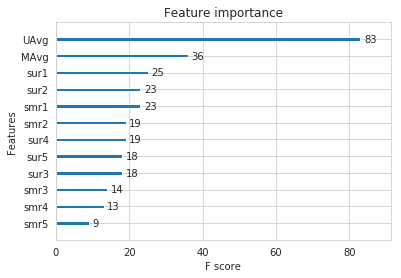

In [21]:
%matplotlib inline

first_xgb = first_xbg
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

<h3> 4.4.2 Suprise BaselineModel </h3>
    


In [0]:
from surprise import BaselineOnly 

__Predicted_rating : ( baseline prediction ) __

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

__Optimization function ( Least Squares Problem ) __

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [23]:

# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:05.701762 

Evaluating the model with train data..
time taken : 0:00:06.752526
---------------
Train Data
---------------
RMSE : 0.9224990874903779

MAPE : 28.69175561741864

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.999818
---------------
Test Data
---------------
RMSE : 1.0906841722187548

MAPE : 35.03549054586883

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:13.456023


<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__Updating Train Data__

In [24]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,174683,10,3.581691,5.0,4.0,4.0,5.0,4.0,3.0,4.0,3.0,2.0,4.0,3.793103,3.611111,5,3.629662
1,233949,10,3.581691,4.0,4.0,5.0,5.0,1.0,2.0,2.0,3.0,3.0,3.0,2.696970,3.611111,3,3.668190


__Updating Test Data__

In [25]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,1129620,2,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3,3.581691
1,779046,71,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,5,3.581691


In [26]:
import warnings
warnings.filterwarnings("ignore")
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# running XGBoost model...
depths = [2, 3, 5]
estimators = [100, 300, 500]

xgb_bsl, train_results, test_results = \
      hyperpar_xgb_run(depths, estimators, x_train, y_train, x_test, y_test)


For max_depth = 2 and n_estimators = 100:

Training the model..
[08:32:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:16.149396

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.09138927836392
MAPE :  35.06897200613277


For max_depth = 2 and n_estimators = 300:

Training the model..
[08:32:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:44.516054

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.093134643289765
MAPE :  35.010618014376654


For max_depth = 2 and n_estimators = 500:

Training the model..
[08:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:01:15.19

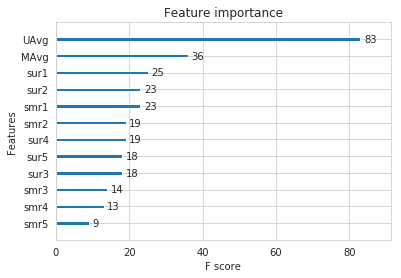

In [27]:
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

In [0]:
from surprise import KNNBaseline

- KNN BASELINE
    - http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 

- PEARSON_BASELINE SIMILARITY
    - http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline 

- SHRINKAGE
    - _2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf 

- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
       

- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

  <h4> 4.4.4.1 Surprise KNNBaseline with user user similarities</h4>

**I am not tuning hyper-parameters for KNNBaseline model as it takes lot of RAM and shuts the colab.**

In [29]:
sim_options = {'user_based' : True,
              'name': 'pearson_baseline',
              'shrinkage': 100,
              'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}

knn_model = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
train_results, test_results = run_surprise(knn_model, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = train_results
models_evaluation_test['knn_bsl_u'] = test_results

knn_bsl_u = knn_model

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:05:58.909797 

Evaluating the model with train data..
time taken : 0:24:29.529143
---------------
Train Data
---------------
RMSE : 0.43695673554824344

MAPE : 12.316741435069908

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.123451
---------------
Test Data
---------------
RMSE : 1.0912113839042437

MAPE : 35.04687078196327

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:30:29.565376


<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [30]:
sim_options = {'user_based' : False,
              'name': 'pearson_baseline',
              'shrinkage': 100,
              'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}

knn_model = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)
train_results, test_results = run_surprise(knn_model, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = train_results
models_evaluation_test['knn_bsl_m'] = test_results

knn_bsl_m = knn_model

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:10.232411 

Evaluating the model with train data..
time taken : 0:01:44.905039
---------------
Train Data
---------------
RMSE : 0.48336909067160244

MAPE : 13.48133560351244

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.039677
---------------
Test Data
---------------
RMSE : 1.0913716198974626

MAPE : 35.049830643994326

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:01:56.179521


<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

- - - First we will run XGBoost with predictions from both KNN's ( that uses User\_User and Item\_Item similarities along with our previous features.

 
- - - Then we will run XGBoost with just predictions form both knn models and preditions from our baseline model. 

__Preparing Train data __

In [31]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,174683,10,3.581691,5.0,4.0,4.0,5.0,4.0,3.0,4.0,3.0,2.0,4.0,3.793103,3.611111,5,3.629662,4.965611,4.888374
1,233949,10,3.581691,4.0,4.0,5.0,5.0,1.0,2.0,2.0,3.0,3.0,3.0,2.696970,3.611111,3,3.668190,3.202209,3.286666


__Preparing Test data  __

In [32]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,1129620,2,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3,3.581691,3.581691,3.581691
1,779046,71,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,5,3.581691,3.581691,3.581691


In [33]:
import warnings
warnings.filterwarnings("ignore")
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# running XGBoost model...
depths = [2, 3, 5]
estimators = [100, 300, 500]

xgb_knn_bsl, train_results, test_results = \
      hyperpar_xgb_run(depths, estimators, x_train, y_train, x_test, y_test)


For max_depth = 2 and n_estimators = 100:

Training the model..
[09:16:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:19.220906

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.09138927836392
MAPE :  35.06897200613277


For max_depth = 2 and n_estimators = 300:

Training the model..
[09:16:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:55.873750

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0931241068855206
MAPE :  35.00846024128173


For max_depth = 2 and n_estimators = 500:

Training the model..
[09:17:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:01:32.22

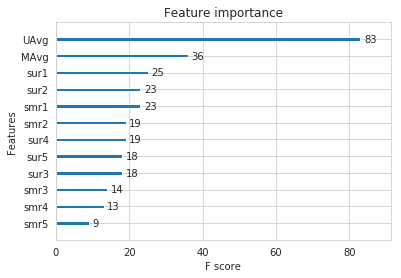

In [34]:
# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results

xgb.plot_importance(xgb_knn_bsl)
plt.show()

<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

In [0]:
from surprise import SVD

http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD 

- __ Predicted Rating : __
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        


- A BASIC MATRIX FACTORIZATION MODEL in  https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [36]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:45.181135 

Evaluating the model with train data..
time taken : 0:00:07.762425
---------------
Train Data
---------------
RMSE : 0.6733835409203514

MAPE : 20.050274566430474

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.965977
---------------
Test Data
---------------
RMSE : 1.090732194420088

MAPE : 34.974384804732125

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:53.911848


  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

In [0]:
from surprise import SVDpp

- ----->  2.5 Implicit Feedback in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

- __ Predicted Rating : __
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 

 - $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [38]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:28:43.713504 

Evaluating the model with train data..
time taken : 0:01:19.153760
---------------
Train Data
---------------
RMSE : 0.6551590292181674

MAPE : 18.934401555091707

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:01.099742
---------------
Test Data
---------------
RMSE : 1.0911289051014106

MAPE : 34.91855569731148

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:30:03.970648


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__Preparing Train data__

In [39]:
# add the predicted values from both knns to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,174683,10,3.581691,5.0,4.0,4.0,5.0,4.0,3.0,4.0,3.0,2.0,4.0,3.793103,3.611111,5,3.629662,4.965611,4.888374,3.954657,3.938250
1,233949,10,3.581691,4.0,4.0,5.0,5.0,1.0,2.0,2.0,3.0,3.0,3.0,2.696970,3.611111,3,3.668190,3.202209,3.286666,3.655824,3.429631


__Preparing Test data  __

In [40]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,1129620,2,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3,3.581691,3.581691,3.581691,3.581691,3.581691
1,779046,71,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,3.581691,5,3.581691,3.581691,3.581691,3.581691,3.581691


In [42]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']

depths = [2, 3, 5]
estimators = [100, 300, 500]

xgb_final, train_results, test_results = \
      hyperpar_xgb_run(depths, estimators, x_train, y_train, x_test, y_test)


For max_depth = 2 and n_estimators = 100:

Training the model..
[10:12:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:21.106084

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.09138927836392
MAPE :  35.06897200613277


For max_depth = 2 and n_estimators = 300:

Training the model..
[10:13:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:01:03.937359

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.093099664260115
MAPE :  35.01088272957672


For max_depth = 2 and n_estimators = 500:

Training the model..
[10:14:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:01:40.623

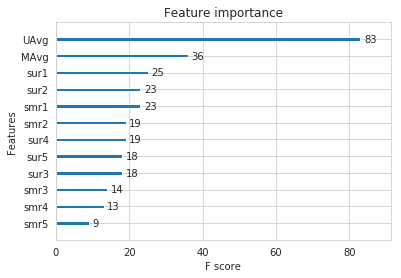

In [43]:
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

In [44]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']

depths = [2, 3, 5]
estimators = [100, 300, 500]

xgb_all_models, train_results, test_results = \
      hyperpar_xgb_run(depths, estimators, x_train, y_train, x_test, y_test)


For max_depth = 2 and n_estimators = 100:

Training the model..
[10:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:12.535367

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0990755568997919
MAPE :  35.43721353310102


For max_depth = 2 and n_estimators = 300:

Training the model..
[10:29:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:36.051310

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0992905204017764
MAPE :  35.43298225022281


For max_depth = 2 and n_estimators = 500:

Training the model..
[10:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:56.

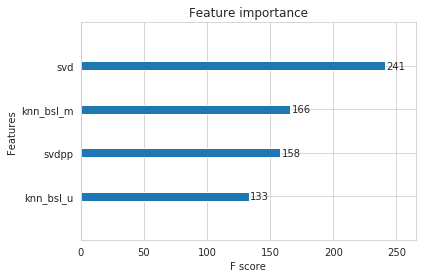

In [45]:
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

## Conclusion

In [0]:
rmse_train_results = dict([(x, y['rmse']) for x, y in models_evaluation_train.items()])
rmse_test_results = dict([(x, y['rmse']) for x, y in models_evaluation_test.items()])

In [0]:
models = {'first_algo': first_xgb, 'bsl_algo': bsl_algo, 'xgb_bsl': xgb_bsl,
          'knn_bsl_u': knn_bsl_u, 'knn_bsl_m': knn_bsl_m, 'xgb_knn_bsl': xgb_knn_bsl,
          'svd': svd, 'svdpp': svdpp, 'xgb_all_models': xgb_all_models, 'xgb_final': xgb_final}

In [0]:
hyper_params = {'first_algo': 'depth: 2, n_estim: 100', 'bsl_algo': '-',\
                'xgb_bsl': 'depth: 2, n_estim: 100', 'knn_bsl_u': 'shrinkage: 100, k: 40',\
                'knn_bsl_m': 'shrinkage: 100, k: 40', 'xgb_knn_bsl': 'depth: 2, n_estim: 100',\
                'svd': 'n_factors: 100', 'svdpp': 'n_factors: 50',\
                'xgb_all_models': 'depth: 3, n_estim: 100', 'xgb_final': 'depth: 2, n_estim: 100'}

In [84]:
from prettytable import PrettyTable

table = PrettyTable()

table.field_names = ['Model', 'hyper-params', 'Train RMSE', 'Test RMSE']
for key in models.keys():
  table.add_row([key, hyper_params[key], rmse_train_results[key], rmse_test_results[key]])

print(table)

+----------------+------------------------+---------------------+--------------------+
|     Model      |      hyper-params      |      Train RMSE     |     Test RMSE      |
+----------------+------------------------+---------------------+--------------------+
|   first_algo   | depth: 2, n_estim: 100 |  0.8627553985802527 |  1.09138927836392  |
|    bsl_algo    |           -            |  0.9224990874903779 | 1.0906841722187548 |
|    xgb_bsl     | depth: 2, n_estim: 100 |  0.8627553985802527 |  1.09138927836392  |
|   knn_bsl_u    | shrinkage: 100, k: 40  | 0.43695673554824344 | 1.0912113839042437 |
|   knn_bsl_m    | shrinkage: 100, k: 40  | 0.48336909067160244 | 1.0913716198974626 |
|  xgb_knn_bsl   | depth: 2, n_estim: 100 |  0.8627553985802527 |  1.09138927836392  |
|      svd       |     n_factors: 100     |  0.6733835409203514 | 1.090732194420088  |
|     svdpp      |     n_factors: 50      |  0.6551590292181674 | 1.0911289051014106 |
| xgb_all_models | depth: 3, n_estim: 100 |

 **Conclusion:**
 - **Took 25K users and 2.5K movies to prepare Train data and 12.5K users and 1.25K movies to prepare Test data.**
 - **Optimized the code for preperation of Train data and checked if it gives any different results. Preparing Train data took lot of time (~ 27 hours) even after optimising the code. (This is done in my PC as Colab wont allow long runs)**
 - **The results are not satisfactory even after hyper-parameter tuning the XGBoost Models. Every model's test RMSE is around 1.09 and adding additional features seems to be not improving the RMSE.**
 - **Surprise Baseline model gave best RMSE among all the models but there is no significant difference between models performances to declare it as the best.**
 - **User Average and movie Average are important features in all of the XGBoost models. So User bias is an important feature for predicting the rating of a cell**
 - **KNN models seems to be overfitting. Hyper-parameter tuning is not done on them because the session fails due to exceed in memory while doing the hyper-parameter tuning (even with 24GB RAM).**
 - **Increase in data is solution for better results but not able to do in time as my PC is a low end PC and Colab wont allow such long runs of session. (Preparing Train data in my PC)**